In [107]:
TARGET_ITERATION = 3

In [108]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# Load pipeline results data
with open('pipeline_results.json', 'r') as f:
    data = json.load(f)

print(f"Total executions: {data['count']}")
print(f"Last updated: {data['updated_at']}")

# Analyze data structure
executions = data['executions']
print(f"\nExecution conversations: {len(executions)}")

# Count conversations by number of iterations
iteration_counts = defaultdict(int)
for conv_id, execution in executions.items():
    iteration_counts[execution['total_iterations']] += 1
    
print("\nIterations distribution:")
for iterations, count in sorted(iteration_counts.items()):
    print(f"  {iterations} iteration(s): {count} conversations")


Total executions: 103
Last updated: 2025-10-02T01:36:05.2432525-03:00

Execution conversations: 103

Iterations distribution:
  1 iteration(s): 8 conversations
  2 iteration(s): 78 conversations
  3 iteration(s): 17 conversations


In [109]:
# Filter conversations that have the target number of iterations for comparison and group by model
target_iteration_conversations = []
for conv_id, execution in executions.items():
    if execution['total_iterations'] >= TARGET_ITERATION:
        target_iteration_conversations.append((conv_id, execution))

print(f"Conversations with {TARGET_ITERATION}+ iterations: {len(target_iteration_conversations)}")

# Group conversations by model
model_groups = defaultdict(list)
for conv_id, execution in target_iteration_conversations:
    # Get model from execution or use default if not available
    model = execution.get('model', 'chatgpt-4o-latest')  # Default model if not specified
    model_groups[model].append((conv_id, execution))

print(f"\nModels found:")
for model, conversations in model_groups.items():
    print(f"  {model}: {len(conversations)} conversations")

# Extract metrics for each model
model_data = {}
for model, conversations in model_groups.items():
    if len(conversations) == 0:
        continue
        
    print(f"\nProcessing model: {model}")
    
    # Create dynamic metrics data structure based on target iteration
    metrics_data = {
        'conversation_id': [],
        'final_success': []
    }
    
    # Add columns for each iteration up to target iteration
    for i in range(1, TARGET_ITERATION + 1):
        metrics_data[f'iteration_{i}_parse_success_rate'] = []
        metrics_data[f'iteration_{i}_execution_success_rate'] = []
        metrics_data[f'iteration_{i}_overall_success_rate'] = []
        metrics_data[f'iteration_{i}_total_statements'] = []
        metrics_data[f'iteration_{i}_parse_errors'] = []
        metrics_data[f'iteration_{i}_execution_errors'] = []

    for conv_id, execution in conversations:
        # Only process if we have enough iterations
        if len(execution['iteration_results']) >= TARGET_ITERATION:
            metrics_data['conversation_id'].append(conv_id[:8])  # Short ID for display
            metrics_data['final_success'].append(execution['final_success'])
            
            # Add data for each iteration up to target iteration
            for i in range(1, TARGET_ITERATION + 1):
                iter_data = execution['iteration_results'][i-1]  # 0-based indexing
                metrics_data[f'iteration_{i}_parse_success_rate'].append(iter_data['parse_success_rate'])
                metrics_data[f'iteration_{i}_execution_success_rate'].append(iter_data['execution_success_rate'])
                metrics_data[f'iteration_{i}_overall_success_rate'].append(iter_data['overall_success_rate'])
                metrics_data[f'iteration_{i}_total_statements'].append(iter_data['total_statements'])
                metrics_data[f'iteration_{i}_parse_errors'].append(iter_data['parse_errors'])
                metrics_data[f'iteration_{i}_execution_errors'].append(iter_data['execution_errors'])

    # Create DataFrame for this model
    df = pd.DataFrame(metrics_data)
    model_data[model] = df
    print(f"  DataFrame shape: {df.shape}")
    print(f"  Final success rate: {df['final_success'].mean():.1%}")


Conversations with 3+ iterations: 17

Models found:
  gpt-5-mini-2025-08-07: 10 conversations
  chatgpt-4o-latest: 7 conversations

Processing model: gpt-5-mini-2025-08-07
  DataFrame shape: (10, 20)
  Final success rate: 0.0%

Processing model: chatgpt-4o-latest
  DataFrame shape: (7, 20)
  Final success rate: 14.3%



=== Creating plots for model: gpt-5-mini-2025-08-07 ===


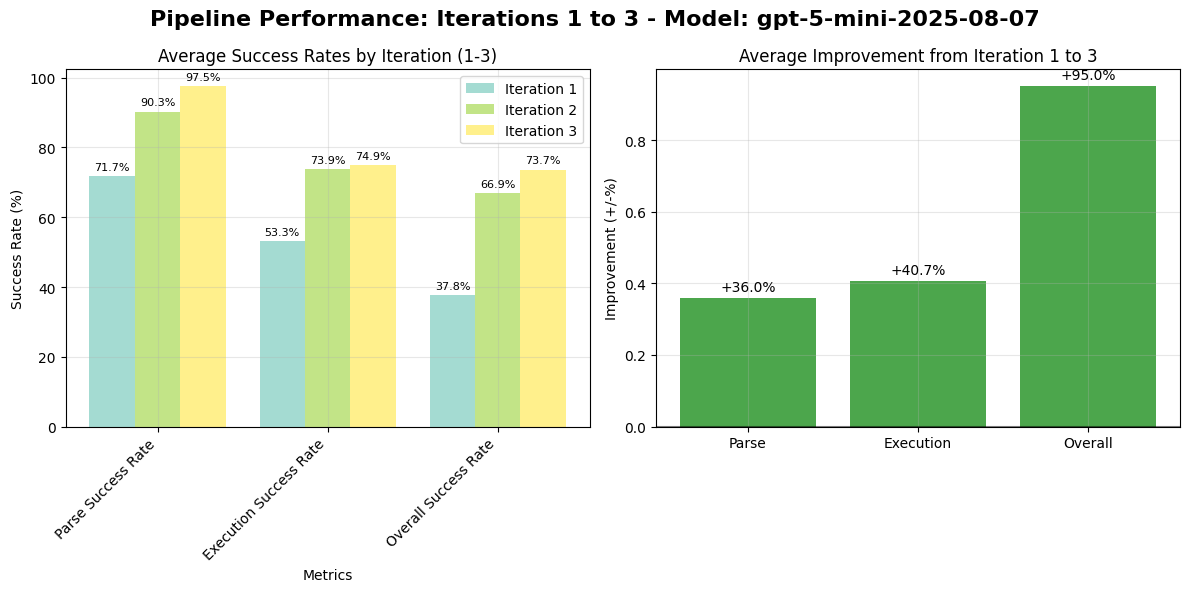


=== Creating plots for model: chatgpt-4o-latest ===


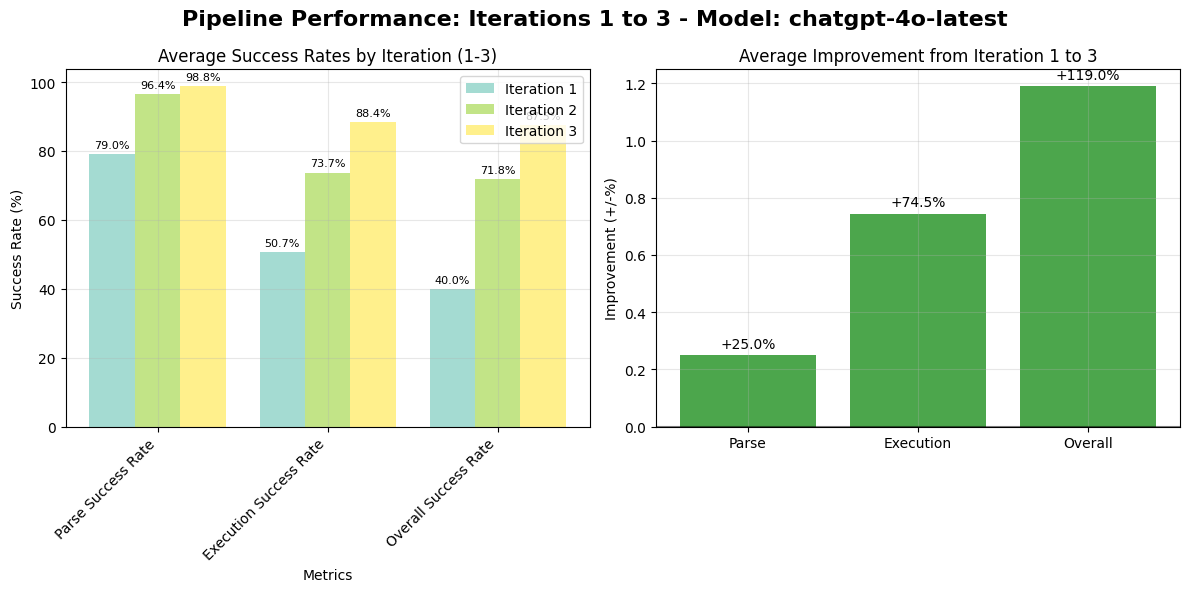


=== Cross-Model Comparison Summary ===


C:\Users\sebad\AppData\Local\Temp\ipykernel_15324\921517810.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models, rotation=45, ha='right')


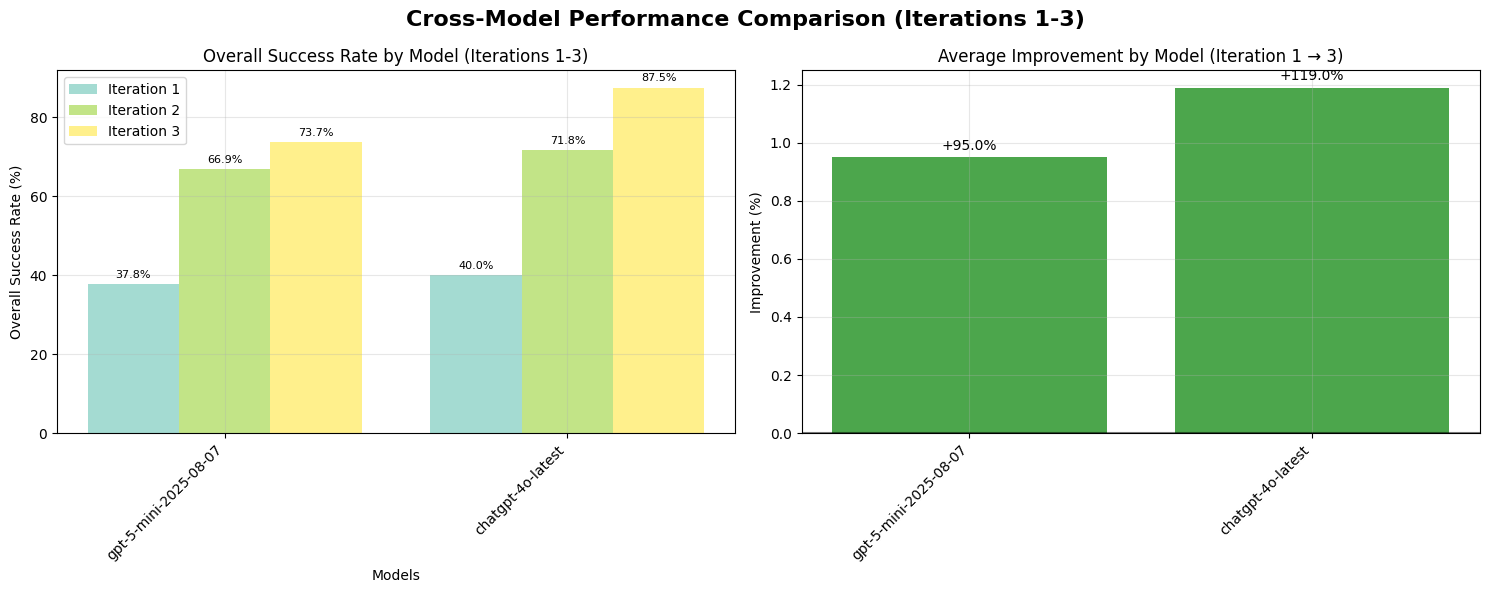

In [110]:
# Create comprehensive comparison visualizations for each model
plt.style.use('default')

def create_model_comparison_plots(model_name, df):
    """Create comparison plots for a specific model"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Pipeline Performance: Iterations 1 to {TARGET_ITERATION} - Model: {model_name}', fontsize=16, fontweight='bold')

    # Define width for all plots
    width = 0.8 / TARGET_ITERATION  # Adjust width based on number of iterations

    # 1. Success Rates Comparison (Bar Chart) - All iterations
    ax1 = axes[0]
    success_metrics = ['Parse Success Rate', 'Execution Success Rate', 'Overall Success Rate']
    
    # Create data for all iterations
    iteration_means = {}
    for i in range(1, TARGET_ITERATION + 1):
        iteration_means[f'iteration_{i}'] = [
            df[f'iteration_{i}_parse_success_rate'].mean(),
            df[f'iteration_{i}_execution_success_rate'].mean(),
            df[f'iteration_{i}_overall_success_rate'].mean()
        ]

    x = np.arange(len(success_metrics))
    colors = plt.cm.Set3(np.linspace(0, 1, TARGET_ITERATION))
    
    # Create bars for each iteration
    bars_all = []
    for i, (iter_key, means) in enumerate(iteration_means.items()):
        iteration_num = i + 1
        bars = ax1.bar(x + (i - (TARGET_ITERATION-1)/2) * width, means, width, 
                      label=f'Iteration {iteration_num}', alpha=0.8, color=colors[i])
        bars_all.append(bars)

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title(f'Average Success Rates by Iteration (1-{TARGET_ITERATION})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(success_metrics, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bars in bars_all:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    # 2. Improvement Analysis - First vs Last iteration
    ax2 = axes[1]
    
    # Calculate improvement from iteration 1 to TARGET_ITERATION
    first_iter_parse = df['iteration_1_parse_success_rate'].mean()
    first_iter_exec = df['iteration_1_execution_success_rate'].mean()
    first_iter_overall = df['iteration_1_overall_success_rate'].mean()
    
    last_iter_parse = df[f'iteration_{TARGET_ITERATION}_parse_success_rate'].mean()
    last_iter_exec = df[f'iteration_{TARGET_ITERATION}_execution_success_rate'].mean()
    last_iter_overall = df[f'iteration_{TARGET_ITERATION}_overall_success_rate'].mean()
    
    # Calculate relative improvements (avoiding division by zero)
    parse_improvement = (last_iter_parse / first_iter_parse - 1) if first_iter_parse > 0 else 0
    exec_improvement = (last_iter_exec / first_iter_exec - 1) if first_iter_exec > 0 else 0
    overall_improvement = (last_iter_overall / first_iter_overall - 1) if first_iter_overall > 0 else 0

    improvements = [parse_improvement, exec_improvement, overall_improvement]
    improvement_labels = ['Parse', 'Execution', 'Overall']
    colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]

    bars_imp = ax2.bar(improvement_labels, improvements, color=colors_imp, alpha=0.7)
    ax2.set_ylabel('Improvement (+/-%)')
    ax2.set_title(f'Average Improvement from Iteration 1 to {TARGET_ITERATION}')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add value labels
    for bar, imp in zip(bars_imp, improvements):
        height = bar.get_height()
        ax2.annotate(f'{'+' if height >= 0 else ''}{height*100:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return fig

# Create plots for each model
model_figures = {}
for model_name, df in model_data.items():
    if len(df) > 0:  # Only create plots if we have data
        print(f"\n=== Creating plots for model: {model_name} ===")
        fig = create_model_comparison_plots(model_name, df)
        model_figures[model_name] = fig

# Summary comparison across models
if len(model_data) > 1:
    print(f"\n=== Cross-Model Comparison Summary ===")
    
    # Create summary comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Cross-Model Performance Comparison (Iterations 1-{TARGET_ITERATION})', fontsize=16, fontweight='bold')
    
    models = list(model_data.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    # Overall success rate comparison - All iterations
    ax1 = axes[0]
    iteration_rates = {}
    
    # Collect data for all iterations
    for i in range(1, TARGET_ITERATION + 1):
        iteration_rates[f'iteration_{i}'] = []
        for model in models:
            df = model_data[model]
            iteration_rates[f'iteration_{i}'].append(df[f'iteration_{i}_overall_success_rate'].mean())
    
    x = np.arange(len(models))
    width = 0.8 / TARGET_ITERATION
    colors_iter = plt.cm.Set3(np.linspace(0, 1, TARGET_ITERATION))
    
    # Create bars for each iteration
    bars_all = []
    for i, (iter_key, rates) in enumerate(iteration_rates.items()):
        iteration_num = i + 1
        bars = ax1.bar(x + (i - (TARGET_ITERATION-1)/2) * width, rates, width, 
                      label=f'Iteration {iteration_num}', alpha=0.8, color=colors_iter[i])
        bars_all.append(bars)
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Overall Success Rate (%)')
    ax1.set_title(f'Overall Success Rate by Model (Iterations 1-{TARGET_ITERATION})')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bars in bars_all:
        for bar in bars:
            height = bar.get_height()
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    # Improvement comparison - First vs Last iteration
    ax2 = axes[1]
    improvements = []
    
    for model in models:
        df = model_data[model]
        first_overall = df['iteration_1_overall_success_rate'].mean()
        last_overall = df[f'iteration_{TARGET_ITERATION}_overall_success_rate'].mean()
        
        # Calculate relative improvement (avoiding division by zero)
        overall_improvement = (last_overall / first_overall - 1) if first_overall > 0 else 0
        improvements.append(overall_improvement)
    
    colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
    bars_imp = ax2.bar(models, improvements, color=colors_imp, alpha=0.7)
    ax2.set_ylabel('Improvement (%)')
    ax2.set_title(f'Average Improvement by Model (Iteration 1 → {TARGET_ITERATION})')
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels
    for bar, imp in zip(bars_imp, improvements):
        height = bar.get_height()
        ax2.annotate(f'{'+' if height >= 0 else ''}{height*100:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("Only one model found - no cross-model comparison available")


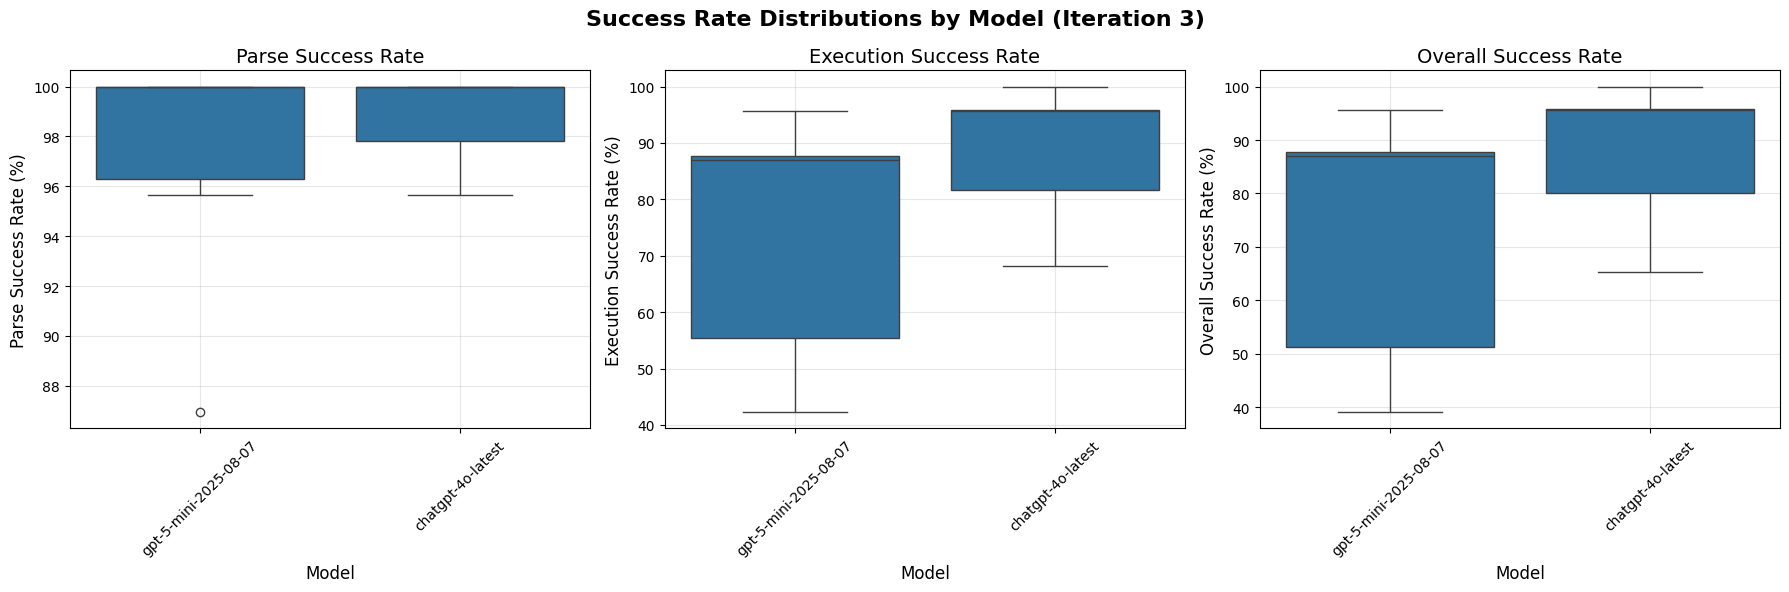

Success Rate Summary by Model (Iteration 3):

gpt-5-mini-2025-08-07:
  Parse     - Mean: 97.5%, Median: 100.0%, Std: 4.1%
  Execution - Mean: 74.9%, Median: 87.0%, Std: 22.1%
  Overall   - Mean: 73.7%, Median: 87.0%, Std: 23.3%

chatgpt-4o-latest:
  Parse     - Mean: 98.8%, Median: 100.0%, Std: 2.1%
  Execution - Mean: 88.4%, Median: 95.7%, Std: 11.8%
  Overall   - Mean: 87.5%, Median: 95.7%, Std: 13.2%


In [111]:
# Create grid of boxplots for different success rates by model
import seaborn as sns

# Prepare data for boxplots - using target iteration
parse_data = []
execution_data = []
overall_data = []

for model_name, df in model_data.items():
    # Parse success rates
    for rate in df[f'iteration_{TARGET_ITERATION}_parse_success_rate']:
        parse_data.append({
            'Model': model_name,
            'Parse Success Rate': rate
        })
    
    # Execution success rates
    for rate in df[f'iteration_{TARGET_ITERATION}_execution_success_rate']:
        execution_data.append({
            'Model': model_name,
            'Execution Success Rate': rate
        })
    
    # Overall success rates
    for rate in df[f'iteration_{TARGET_ITERATION}_overall_success_rate']:
        overall_data.append({
            'Model': model_name,
            'Overall Success Rate': rate
        })

# Convert to DataFrames
parse_df = pd.DataFrame(parse_data)
execution_df = pd.DataFrame(execution_data)
overall_df = pd.DataFrame(overall_data)

# Create the grid of boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Success Rate Distributions by Model (Iteration {TARGET_ITERATION})', fontsize=16, fontweight='bold')

# Plot 1: Parse Success Rate
sns.boxplot(data=parse_df, x='Model', y='Parse Success Rate', ax=axes[0])
axes[0].set_title('Parse Success Rate', fontsize=14)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Parse Success Rate (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Plot 2: Execution Success Rate
sns.boxplot(data=execution_df, x='Model', y='Execution Success Rate', ax=axes[1])
axes[1].set_title('Execution Success Rate', fontsize=14)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Execution Success Rate (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Plot 3: Overall Success Rate
sns.boxplot(data=overall_df, x='Model', y='Overall Success Rate', ax=axes[2])
axes[2].set_title('Overall Success Rate', fontsize=14)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('Overall Success Rate (%)', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for target iteration
print(f"Success Rate Summary by Model (Iteration {TARGET_ITERATION}):")
print("="*60)
for model_name, df in model_data.items():
    # Parse success rates
    parse_mean = df[f'iteration_{TARGET_ITERATION}_parse_success_rate'].mean()
    parse_median = df[f'iteration_{TARGET_ITERATION}_parse_success_rate'].median()
    parse_std = df[f'iteration_{TARGET_ITERATION}_parse_success_rate'].std()
    
    # Execution success rates
    exec_mean = df[f'iteration_{TARGET_ITERATION}_execution_success_rate'].mean()
    exec_median = df[f'iteration_{TARGET_ITERATION}_execution_success_rate'].median()
    exec_std = df[f'iteration_{TARGET_ITERATION}_execution_success_rate'].std()
    
    # Overall success rates
    overall_mean = df[f'iteration_{TARGET_ITERATION}_overall_success_rate'].mean()
    overall_median = df[f'iteration_{TARGET_ITERATION}_overall_success_rate'].median()
    overall_std = df[f'iteration_{TARGET_ITERATION}_overall_success_rate'].std()
    
    print(f"\n{model_name}:")
    print(f"  Parse     - Mean: {parse_mean:.1f}%, Median: {parse_median:.1f}%, Std: {parse_std:.1f}%")
    print(f"  Execution - Mean: {exec_mean:.1f}%, Median: {exec_median:.1f}%, Std: {exec_std:.1f}%")
    print(f"  Overall   - Mean: {overall_mean:.1f}%, Median: {overall_median:.1f}%, Std: {overall_std:.1f}%")
